# introduction

Recently, I’ve been increasingly frustrated with Spotify’s recommendation system. While it does surface songs I enjoy, I noticed that most of the "Discover" playlists and suggested tracks are just songs I already know — often ones I’ve liked or even added to my own playlists. The system feels repetitive, lacking the spark of true discovery.

The idea of building my own recommendation engine — one that actually understands what I like and helps me explore beyond the obvious — had been sitting in the back of my mind for a while. When the final project for my machine learning course came up, it felt like the perfect opportunity to finally bring that idea to life.

This project frames the recommendation task as a **supervised binary classification** problem: given a set of features extracted from a song (such as genre, popularity, tempo, acoustic properties, etc.), the goal is to predict whether or not I would like that song. The model is trained using labeled data: songs I have marked as "liked" are labeled as `1`, and the rest as `0`. The underlying paradigm is purely supervised learning — the system learns to distinguish liked from non-liked songs based on past examples.

To build this dataset, I started from a large playlist of songs I already enjoy. The plan is to extract as much information as possible from these songs using the Spotify API and external datasets — including metadata, genre, and audio features. These are then compared to a much larger set of songs I don’t particularly care about. After preprocessing and balancing the data, various classification models are trained and evaluated, using metrics like F1-score that are well suited for imbalanced recommendation problems.

The final goal is clear: generate a new Spotify playlist, containing only songs I’ve never listened to before, but which my model predicts I would enjoy — ideally surfacing tracks that Spotify itself failed to recommend.

As reference, here is the Spotify playlist I will be using for this project:
[My Playlist](https://open.spotify.com/playlist/3zU9kDDrBvxPaKB6vSDo4Z?si=101b3230e98844b8)


It is a newly created playlist made by concatenating most of my already-existing playlists. It contains more than 2000 tracks and ranges from reggae to chanson française, with a focus on 70s/80s rock genre.

This notebook documents everything that was done in order to have a relevant prediction model.
The first sections of this project (until the section "pipeline: train/test split, standardization) are not necessary for the ML aspect of the project, there purpose was to create a dataset, retrieve information through the Spotify API and modify the dataset.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

import requests
import os
import time
import urllib.parse
import base64

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import plotly.express as px


import xgboost
from xgboost import plot_importance
from xgboost import XGBClassifier



In [ ]:
client_id = os.getenv("SPOTIFY_CLIENT_ID")
client_secret = os.getenv("SPOTIFY_CLIENT_SECRET")
user_id = os.getenv("SPOTIFY_USER_ID")

# exploration of the Spotify API, code to retrieve my songs from my playlist (annex part of the project, but essential)

This part aims at creating the csv of the songs contained in my playlist. It is done through the use of the Spotify API, it is not relevant for the project but I kept the code as an annex.

In [ ]:
# connection to the API
redirect_uri = 'http://localhost:8888/callback'
scope = 'user-library-read playlist-modify-public playlist-modify-private'

auth_url = 'https://accounts.spotify.com/authorize'
params = {
    'client_id': client_id,
    'response_type': 'code',
    'redirect_uri': redirect_uri,
    'scope': scope
}

print("Go to this URL and authorize:", f"{auth_url}?{urllib.parse.urlencode(params)}")


Go to this URL and authorize: https://accounts.spotify.com/authorize?client_id=2dc156e307724f4d945a75559517f5cd&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A8888%2Fcallback&scope=user-library-read+playlist-modify-public+playlist-modify-private


In [ ]:
code = 'AQDxRKME-dKSd5v3n9EvrM9rxQMhbntwZvrlo6vJVNAJGL8918axpQHjzCnmAwtcG_XFWjFikGcMZsRvDa0It6KUEcrCmf5vLqZhUcT966F8yDJlWdRWOS4uCWTmhqGjs4N2Ya-TUFjTJYRFFArcJgHhAV3ga3Q0BMN9gdDHmU_cDqrnT3YXt4z93NbC98ztTWZpxrJf8cMZno6MokD9GegKJzeXQiD8czQorzm7Cfi0lQJFkpucAwsvoFemIU44a1pfvdRf'
auth_str = f"{client_id}:{client_secret}"
b64_auth_str = base64.b64encode(auth_str.encode()).decode()

token_url = 'https://accounts.spotify.com/api/token'
headers = {
    'Authorization': f'Basic {b64_auth_str}',
    'Content-Type': 'application/x-www-form-urlencoded'
}
data = {
    'grant_type': 'authorization_code',
    'code': code,
    'redirect_uri': redirect_uri
}

response = requests.post(token_url, headers=headers, data=data)
tokens = response.json()
access_token = tokens['access_token']
print("Access Token:", access_token)


Access Token: BQDPsIQWJYneeGCILooUmJbgFkKa1CTeim2sljjo0jX1W3h7768qJl5TQiXxIkkaz4I5wn0Gn9h_JIhbvlVQMYM2tg7eS7UczN1n0NGD39Mtg2yMzZbfzhgrkt_uL2vWUnT7yV4VBzOADFBDm5PYxKOMHs-VQx7ji4qHkBe4biLc-QN_N7FnAezzj_C6c2DqtfxChk2A_ZGub_SPNsPaDTFES_3Wz9vDsDctmoxBGrA_uttzMmBGI0AR1YVoQsNLs07Ykqg4H3j9GypHY8wExDKr71KngBmWLUk


In [ ]:
token_type = tokens.get('token_type')
scope = tokens.get('scope')

print("Access Token:", access_token)
print("Token Type:", token_type)
print("Scope:", scope)

Access Token: BQBntZ4xuFGKeaDdN9ENbTOraPJJTlVUaxQNGEcfwRItkHjwGjDXuyWGxInUs8hyQXhvYSRver2mU9B3K9j33XT04oq-tZzWccTYY4u_RD9OJgvrCdm_G6jvGTkGuTZWw8oi6Fq9jzeSwYOOj2RAdFWiYtT2RjdDZ4AEoW_j7ryoU7CW6-1IPGjI34B6k-U51J4Vn61aeimRAFA_oFvMYEyCBVAIhAZwZwRh
Token Type: Bearer
Scope: user-library-read


In [ ]:

headers = {
    'Authorization': f'Bearer {access_token}'
}

all_tracks = []
limit = 50
offset = 0

while True:
    url = f'https://api.spotify.com/v1/me/tracks?limit={limit}&offset={offset}'
    response = requests.get(url, headers=headers)
    data = response.json()

    if response.status_code != 200:
        print(f"Failed at offset {offset}: {response.status_code}")
        print(response.text)
        break

    items = data.get('items', [])
    if not items:
        break

    all_tracks.extend(items)
    print(f"Fetched {len(all_tracks)} tracks so far...")

    offset += limit
    time.sleep(0.1)  # to be nice to the API

# Display track names
for item in all_tracks:
    track = item['track']
    name = track['name']
    artists = ', '.join([a['name'] for a in track['artists']])
    print(f"{name} by {artists}")

print(f"Total Liked Songs: {len(all_tracks)}")

Fetched 50 tracks so far...
Fetched 100 tracks so far...
Fetched 150 tracks so far...
Fetched 200 tracks so far...
Fetched 250 tracks so far...
Fetched 300 tracks so far...
Fetched 350 tracks so far...
Fetched 400 tracks so far...
Fetched 450 tracks so far...
Fetched 500 tracks so far...
Fetched 550 tracks so far...
Fetched 600 tracks so far...
Fetched 650 tracks so far...
Fetched 700 tracks so far...
Fetched 750 tracks so far...
Fetched 800 tracks so far...
Fetched 850 tracks so far...
Fetched 900 tracks so far...
Fetched 950 tracks so far...
Fetched 1000 tracks so far...
Fetched 1050 tracks so far...
Fetched 1100 tracks so far...
Fetched 1150 tracks so far...
Fetched 1200 tracks so far...
Fetched 1250 tracks so far...
Fetched 1300 tracks so far...
Fetched 1350 tracks so far...
Fetched 1400 tracks so far...
Fetched 1450 tracks so far...
Fetched 1500 tracks so far...
Fetched 1550 tracks so far...
Fetched 1600 tracks so far...
Fetched 1650 tracks so far...
Fetched 1700 tracks so far...


In [ ]:
# --- Retrieving all my playlists name and ID to find the playlist im intrested in ---

def get_user_playlists(token):
    url = "https://api.spotify.com/v1/me/playlists"
    headers = {"Authorization": f"Bearer {token}"}
    playlists = []

    while url:
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            print(f"Erreur {response.status_code} : {response.text}")
            break
        data = response.json()
        playlists.extend(data['items'])
        url = data.get('next')  # Pagination

    for p in playlists:
        print(f"🎵 {p['name']} — ID: {p['id']} — {p['tracks']['total']} tracks")

get_user_playlists(access_token)

🎵 ML Recommendations — ID: 5uKn4ly10ZHqSlG4N1xZ0U — 100 tracks
🎵 My playlist — ID: 3zU9kDDrBvxPaKB6vSDo4Z — 2931 tracks
🎵 🎻 - classique - 🎻 — ID: 669cU7LtslZN5GrEJsmr21 — 62 tracks
🎵 🎸- rock - 🎸 — ID: 67wz9tTNCvWDOauO5TMyr2 — 269 tracks
🎵 🪕 - acoustic - 🪕 — ID: 4CqdAZYkJKeS6uBSZv8wpC — 28 tracks
🎵 🎷 - jazz - 🎷 — ID: 6imab6qc4pBggjonea0KEr — 63 tracks
🎵 🎖️ - Mili - 🎖️ — ID: 4g7BFg2WdRPlCWnIR0Lrnf — 48 tracks
🎵 💯 - random - 💯 — ID: 5XPLwTVQ2sFmpnW4q9Qo2p — 2780 tracks
🎵 🤘 - Metal - 🤘 — ID: 5fCbrQGz8sxNGQOinngtsk — 46 tracks
🎵 🇫🇷 - Variété francaise - 🇫🇷 — ID: 7GeJJs6oU223ira8M7NpAf — 261 tracks
🎵 🖤 - michael - 🤍 — ID: 6Qe2gGt9KZHWYjTJhiXDA7 — 68 tracks
🎵 🇯🇲 - Reggae - 🇯🇲 — ID: 2y8ZfIQJ8U412OMyC2YCw8 — 47 tracks


In [ ]:
# --- creation of a csv file containing the metadata of my playlist ---

headers = {'Authorization': f'Bearer {access_token}'}
playlist_id = "3zU9kDDrBvxPaKB6vSDo4Z"

def get_playlist_tracks():
    all_tracks = []
    url = f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks'
    while url:
        response = requests.get(url, headers=headers)
        data = response.json()

        if response.status_code != 200:
            print("Erreur récupération playlist:", response.status_code, response.text)
            break

        items = data.get('items', [])
        for item in items:
            track = item.get('track')
            if not track or not track.get('id'):
                continue
            all_tracks.append(track)

        url = data.get('next')
        time.sleep(0.1)

    print(f"{len(all_tracks)} tracks acquired from the playlist.")
    return all_tracks

def get_artist_genres(artist_ids):
    genre_map = {}
    unique_ids = list(set(artist_ids))
    for i in range(0, len(unique_ids), 50):
        batch = unique_ids[i:i + 50]
        ids_param = ','.join(batch)
        url = f'https://api.spotify.com/v1/artists?ids={ids_param}'
        response = requests.get(url, headers=headers)
        data = response.json()
        for artist in data.get('artists', []):
            genre_map[artist['id']] = ', '.join(artist.get('genres', []))
        time.sleep(0.1)
    return genre_map

def create_csv():
    tracks = get_playlist_tracks()
    track_info = []
    artist_ids = []

    for track in tracks:
        main_artist = track['artists'][0]
        artist_ids.append(main_artist['id'])

        track_info.append({
            'id': track['id'],
            'name': track['name'],
            'artists': ', '.join(a['name'] for a in track['artists']),
            'album': track['album']['name'],
            'duration_ms': track['duration_ms'],
            'popularity': track['popularity'],
            'explicit': track['explicit'],
            'artist_id': main_artist['id']
        })

    print("getting the genres...")
    genre_map = get_artist_genres(artist_ids) # getting the genres through a new API call

    for info in track_info:
        info['genres'] = genre_map.get(info['artist_id'], 'Unknown')

    df = pd.DataFrame(track_info)
    df.drop(columns=['artist_id'], inplace=True)

    df = df.drop_duplicates(subset='id')
    df = df.drop_duplicates(subset='id')


    df.to_csv("all_my_songs.csv", index=False, encoding='utf-8')

    print(f"dataset generated, contains {len(df)} songs.")

create_csv()

➡️ 2931 titres récupérés depuis la playlist.
📥 Récupération des genres...
✅ dataset generated, contains 2926 songs.


# Dataset creation

## only keeping the songs for which I can find the audio features in the big data set

### Why only keeping songs present in the big dataset ?

Since November 2024, Spotify has restricted access to audio features via its public API, making it no longer possible to retrieve detailed acoustic information (e.g. valence, danceability, energy) for arbitrary tracks in a user's library. As a result, I had to rely on an external dataset containing pre-computed audio features for over 80,000 tracks.

To integrate these features into my model, I filtered my liked songs to retain only those present in the external dataset. While this step introduced a trade-off — notably the exclusion of many niche or regional songs — it was necessary in order to include rich acoustic information in the learning process.

I considered this compromise reasonable, as audio features might play a significant role in shaping my musical preferences, especially in capturing subtle aspects like mood, rhythm, or vocal energy that are not reflected in metadata alone.


I start by creating a flag column in the spotify data set:
- 1 if the song is present in my playlist
- 0 otherwise

This will act our target feature to predict to fall in the paradigm of **supervised learning binary classification**.


We also clear the dataset from duplicated songs

In [ ]:
liked_df = pd.read_csv("all_my_songs.csv").drop_duplicates(subset='id')
liked_df = liked_df.dropna(subset=['name'])
liked_ids = set(liked_df['id'].dropna())

audio_df = pd.read_csv("spotify_songs_with_audio_features.csv")
audio_df = audio_df.drop_duplicates(subset='track_id')
audio_df = audio_df.drop_duplicates(subset=['track_name','artists'])


# add column "liked"
audio_df['liked'] = audio_df['track_id'].apply(lambda x: 1 if x in liked_ids else 0)

#save the new csv
audio_df.to_csv("data.csv", index=False, encoding='utf-8')
print(f"✅ 'liked' column added. Total liked in dataset: {audio_df['liked'].sum()}")


✅ 'liked' column added. Total liked in dataset: 641


In [ ]:
liked_df = pd.read_csv("data.csv")

liked_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81344 entries, 0 to 81343
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        81344 non-null  int64  
 1   track_id          81344 non-null  object 
 2   artists           81343 non-null  object 
 3   album_name        81343 non-null  object 
 4   track_name        81343 non-null  object 
 5   popularity        81344 non-null  int64  
 6   duration_ms       81344 non-null  int64  
 7   explicit          81344 non-null  bool   
 8   danceability      81344 non-null  float64
 9   energy            81344 non-null  float64
 10  key               81344 non-null  int64  
 11  loudness          81344 non-null  float64
 12  mode              81344 non-null  int64  
 13  speechiness       81344 non-null  float64
 14  acousticness      81344 non-null  float64
 15  instrumentalness  81344 non-null  float64
 16  liveness          81344 non-null  float6

## Adding the column release_year to the dataframe




I reuse the Spotify API to retrieve the release year of every track (I know it to be an important feature of my music taste, so it better be present). We don't have direct access to the feature, but we can look for the release date of the album of a track, then we add the year to a new column

In [ ]:

# getting the release_year of a song through API call with track_id
def get_release_years(track_ids, access_token):
    release_years = {}
    headers = {'Authorization': f'Bearer {access_token}'}
    base_url = 'https://api.spotify.com/v1/tracks'

    for i in range(0, len(track_ids), 50):
        print(f"batch {i}")
        batch = track_ids[i:i+50]
        ids_param = ','.join(batch)
        while True:
            response = requests.get(f"{base_url}?ids={ids_param}", headers=headers)

            if response.status_code == 429:
                wait = int(response.headers.get("Retry-After", 5))
                print(f"⏳ Rate limited — waiting {wait} seconds...")
                time.sleep(wait)
                continue  # retry same batch

            elif response.status_code == 200:
                results = response.json().get('tracks', [])
                for track in results:
                    if track and track['album'] and track['album'].get('release_date'):
                        release_date = track['album']['release_date']
                        release_years[track['id']] = release_date[:4]
                break  # batch done

            else:
                print(f" API error batch {i}: {response.status_code}")
                break  # optionally skip batch after error
        time.sleep(0.1)  # pause between successful calls
    return release_years





In [ ]:
df = pd.read_csv("data.csv")

# ids of the tracks
ids = list(df['track_id'])

# get years
release_years_map = get_release_years(ids, access_token)


batch 0
batch 50
batch 100
batch 150
batch 200
batch 250
batch 300
batch 350
batch 400
batch 450
batch 500
batch 550
batch 600
batch 650
batch 700
batch 750
batch 800
batch 850
batch 900
batch 950
batch 1000
batch 1050
batch 1100
batch 1150
batch 1200
batch 1250
batch 1300
batch 1350
batch 1400
batch 1450
batch 1500
batch 1550
batch 1600
batch 1650
batch 1700
batch 1750
batch 1800
batch 1850
batch 1900
batch 1950
batch 2000
batch 2050
batch 2100
batch 2150
batch 2200
batch 2250
batch 2300
batch 2350
batch 2400
batch 2450
batch 2500
batch 2550
batch 2600
batch 2650
batch 2700
batch 2750
batch 2800
batch 2850
batch 2900
batch 2950
batch 3000
batch 3050
batch 3100
batch 3150
batch 3200
batch 3250
batch 3300
batch 3350
batch 3400
batch 3450
batch 3500
batch 3550
batch 3600
batch 3650
batch 3700
batch 3750
batch 3800
batch 3850
batch 3900
batch 3950
batch 4000
batch 4050
batch 4100
batch 4150
batch 4200
batch 4250
batch 4300
batch 4350
batch 4400
batch 4450
batch 4500
batch 4550
batch 4600


KeyError: 'id'

In [ ]:
# add release_year column to the dataframe
df['release_year'] = df['track_id'].map(release_years_map)

# save the file containing the release_year column
df.to_csv("data.csv", index=False, encoding='utf-8')

print("release_year added to the dataframe and file saved")

✅ release_year added to the dataframe and file saved


In [ ]:
df = pd.read_csv("data.csv")

# Identify the duplicates
duplicate_tracks = df[audio_df.duplicated(subset='track_id', keep=False)]

# show them
print(f"🎯 {len(duplicate_tracks)} duplicated tracks (according to the id) :")
print(duplicate_tracks[['track_id', 'track_name', 'artists']])

🎯 0 lignes en double sur la base de l'ID :
Empty DataFrame
Columns: [track_id, track_name, artists]
Index: []


In [ ]:
# Load the dataset
liked_df = pd.read_csv("all_my_songs.csv")
ids = liked_df['id'].dropna().unique().tolist()

# Fetch release years
release_years_map = get_release_years(ids, access_token)

# Map into DataFrame
liked_df['release_year'] = liked_df['id'].map(release_years_map)

# Save updated DataFrame
liked_df.to_csv("all_my_songs.csv", index=False, encoding='utf-8')
print("✅ 'release_year' column added and dataset saved.")

batch 0
batch 50
batch 100
batch 150
batch 200
batch 250
batch 300
batch 350
batch 400
batch 450
batch 500
batch 550
batch 600
batch 650
batch 700
batch 750
batch 800
batch 850
batch 900
batch 950
batch 1000
batch 1050
batch 1100
batch 1150
batch 1200
batch 1250
batch 1300
batch 1350
batch 1400
batch 1450
batch 1500
batch 1550
batch 1600
batch 1650
batch 1700
batch 1750
batch 1800
batch 1850
batch 1900
batch 1950
batch 2000
batch 2050
batch 2100
batch 2150
batch 2200
batch 2250
batch 2300
batch 2350
batch 2400
batch 2450
batch 2500
batch 2550
batch 2600
batch 2650
batch 2700
batch 2750
batch 2800
batch 2850
batch 2900
✅ 'release_year' column added and dataset saved.


In [ ]:
audio_df = pd.read_csv("spotify_songs_with_year.csv")
audio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89741 entries, 0 to 89740
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        89741 non-null  int64  
 1   track_id          89741 non-null  object 
 2   artists           89740 non-null  object 
 3   album_name        89740 non-null  object 
 4   track_name        89740 non-null  object 
 5   popularity        89741 non-null  int64  
 6   duration_ms       89741 non-null  int64  
 7   explicit          89741 non-null  bool   
 8   danceability      89741 non-null  float64
 9   energy            89741 non-null  float64
 10  key               89741 non-null  int64  
 11  loudness          89741 non-null  float64
 12  mode              89741 non-null  int64  
 13  speechiness       89741 non-null  float64
 14  acousticness      89741 non-null  float64
 15  instrumentalness  89741 non-null  float64
 16  liveness          89741 non-null  float6

## comparison of release year and popularity between liked songs and matched songs


This part aims at exploring how well the songs contained in my playlist are represented in the dataset I downloaded from Kaggle.

<ipython-input-33-b2f49f2c887b>:26: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


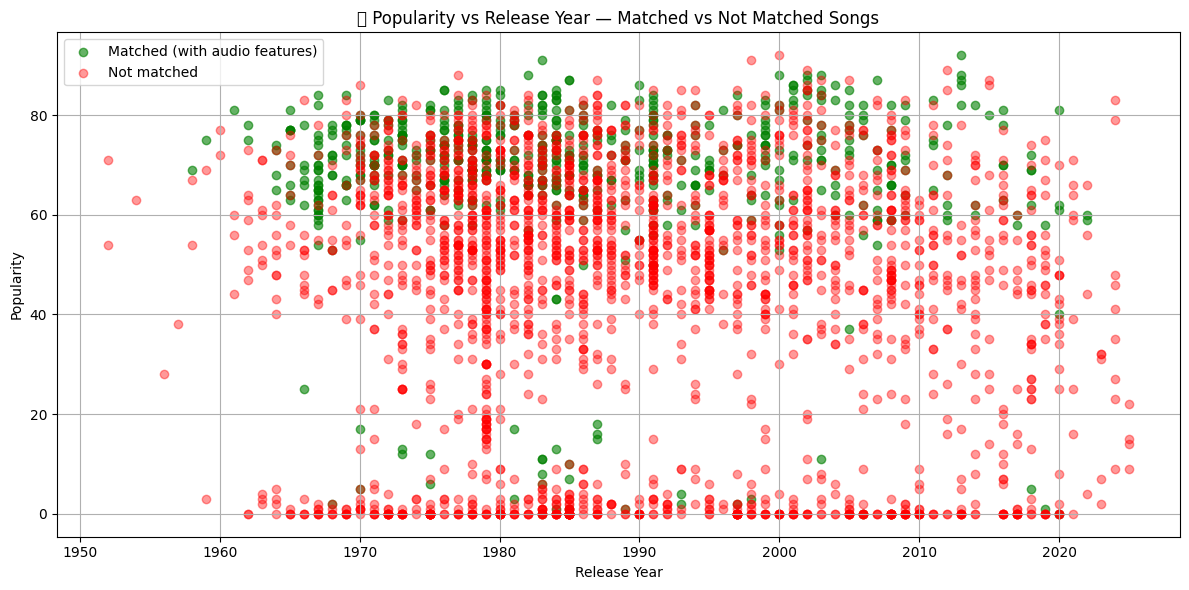

In [ ]:



liked_df = pd.read_csv("all_my_songs.csv")
liked_df = liked_df[liked_df['release_year'] > 0]
df = pd.read_csv("data.csv")

matched_df = df[df['liked'] == 1]

# convert release_year to numeric
liked_df['release_year'] = pd.to_numeric(liked_df['release_year'], errors='coerce')
matched_ids = set(matched_df['track_id'])

# split matched and not matched tracks
liked_df['is_matched'] = liked_df['id'].apply(lambda x: x in matched_ids)
present = liked_df[liked_df['is_matched']]
absent = liked_df[~liked_df['is_matched']]

# plot scatter
plt.figure(figsize=(12, 6))
plt.scatter(present['release_year'], present['popularity'], color='green', alpha=0.6, label='Matched (with audio features)')
plt.scatter(absent['release_year'], absent['popularity'], color='red', alpha=0.4, label='Not matched')
plt.xlabel("Release Year")
plt.ylabel("Popularity")
plt.title("🎵 Popularity vs Release Year — Matched vs Not Matched Songs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

With this graph we can observe that the presence of the songs I like in the dataset is less dependant on the year of release (homogeneous repartition of green points on the x axis) than on the popularity of the song. This is to be expected as the dataset I used contains popular songs.

Another point to mention is the predominance of the year 1979 in the graph. This is due to the release of lots of important albums such as:
- Off the Wall - Michael Jackson
- The Wall - Pink Floyd
- Breakfast in America - Supertramp
- Highway to Hell - AC/DC

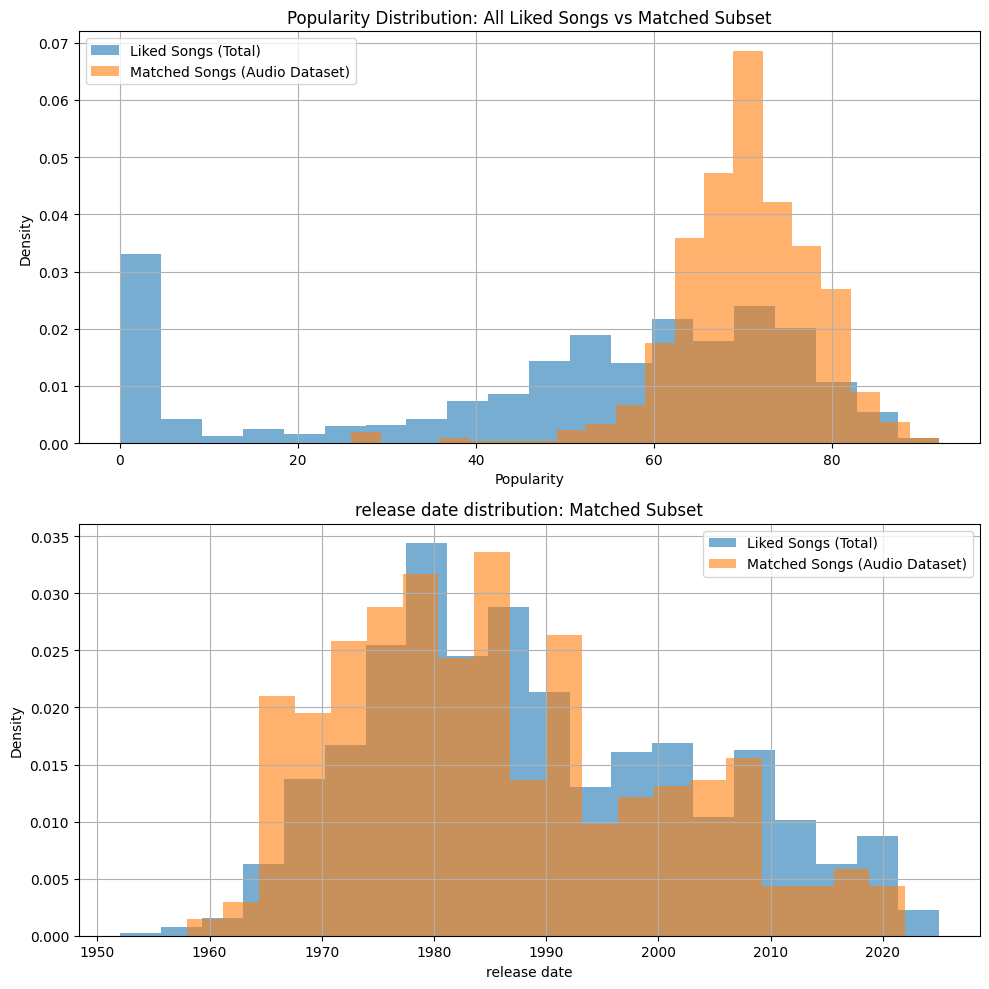

In [ ]:

# histograms for popularity and release year comparison
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.hist(liked_df['popularity'], bins=20, alpha=0.6, label='Liked Songs (Total)', density=True)
plt.hist(matched_df['popularity'], bins=20, alpha=0.6, label='Matched Songs (Audio Dataset)', density=True)
plt.xlabel('Popularity')
plt.ylabel('Density')
plt.title('Popularity Distribution: All Liked Songs vs Matched Subset')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.hist(liked_df['release_year'], bins=20, alpha=0.6, label='Liked Songs (Total)', density=True)
plt.hist(matched_df['release_year'], bins=20, alpha=0.6, label='Matched Songs (Audio Dataset)', density=True)
plt.xlabel('release date')
plt.ylabel('Density')
plt.title('release date distribution: Matched Subset')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



We can observe a bias on the popularity of the song. This was to be expected as the probability that the unpopular songs from my playlist were also present in the Kaggle dataset was a lot smaller compared to more famous tracks.


We can also observe that there do not seem to be a bias on the release year of the matched track.
This suggets an initial good distribution in dates of the dataset containing all songs.

## modifying the size of the dataset

In [ ]:
df = pd.read_csv("data.csv")

liked = df[df['liked'] == 1]
liked.info()


<class 'pandas.core.frame.DataFrame'>
Index: 641 entries, 1932 to 81220
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        641 non-null    int64  
 1   track_id          641 non-null    object 
 2   artists           641 non-null    object 
 3   album_name        641 non-null    object 
 4   track_name        641 non-null    object 
 5   popularity        641 non-null    int64  
 6   duration_ms       641 non-null    int64  
 7   explicit          641 non-null    bool   
 8   danceability      641 non-null    float64
 9   energy            641 non-null    float64
 10  key               641 non-null    int64  
 11  loudness          641 non-null    float64
 12  mode              641 non-null    int64  
 13  speechiness       641 non-null    float64
 14  acousticness      641 non-null    float64
 15  instrumentalness  641 non-null    float64
 16  liveness          641 non-null    float64
 1

In the dataset, there is a significant class imbalance between liked and non-liked songs: approximately 600 songs are labeled as liked (liked = 1), while over 80,000 are not liked (liked = 0). This imbalance can negatively impact any machine learning model that aims to predict or understand user preferences. In such cases, the model may become biased toward predicting the majority class (non-liked), leading to poor performance.

\
To address this issue, I will apply undersampling (randomly reducing the number of non-liked songs) and oversampling (I will artificially increase the number of liked songs by applying a positive probability on songs released by artists I already like).

### Oversampling the number of liked songs

The naive approach I first used was to apply a positive probability on every song by an artist who had already released a song I liked. This led to a wicked solution as for instance:
- I only like one song of an artist, and 1000 songs of him are stored in the dataset
- I apply a $p=0.2$ probability for every song release by a "liked artist" to be included in the songs I like
- then I will go from 1 song to maybe 200 of this artist

To adress this issue I will assign a personalized probability of liking each new song based on how much I already like songs from the same artist.

For each artist, we compute a **liking ratio**:
$$
\text{like ratio}_{\text{artist}} = \frac{\text{Number of liked songs by artist}}{\text{Total number of songs by artist in the dataset}}
$$

This ratio is then used as the **probability \( p \)** in a Bernoulli distribution to randomly assign a synthetic "liked" label (1) to each song:

$$
\text{liked} \sim \text{Binomial}(n=1, p=\text{like\_ratio}_{\text{artist}})
$$

To obtain more songs in the end we then apply the following affine function to the ratio to obtain the probability I will use:

$$
\text{probability} = \frac{1}{factor}*\left(\frac{\text{liked}}{\text{total}}-1\right)+1
$$

$factor \geq 1$ being the factor of amplification (the higher the more likely a song is to be added to the songs I like):
- $factor = 1$: no amplification

This approach helps create a more meaningful dataset by simulating my preference patterns while avoiding unrealistic overfitting to rare artists.

In [ ]:
df = pd.read_csv("data.csv")

liked_df = df[df['liked'] == 1]

#
# Count how many songs per artist I like
liked_artist_counts = liked_df['artists'].value_counts()

# Count total number of songs per artist in the whole dataset
total_artist_counts = df['artists'].value_counts()

# Calculate the ratio and apply the augmention factor
amplification = 2
artist_like_ratio = (1/amplification*(liked_artist_counts/(total_artist_counts)-1)+1).fillna(0)


In [ ]:
candidates = df[df['liked'] == 0].copy()

# Map each candidate song to its artist like ratio
candidates['like_prob'] = candidates['artists'].map(artist_like_ratio).fillna(0)

# Sample synthetic liked flag using Binomial law
candidates['liked'] = candidates['like_prob'].apply(lambda p: np.random.binomial(1, p))

candidates[candidates['liked'] == 1]
df.update(candidates[['liked']])

liked_df = df[df['liked'] == 1]
liked_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2166 entries, 1900 to 81343
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2166 non-null   int64  
 1   track_id          2166 non-null   object 
 2   artists           2166 non-null   object 
 3   album_name        2166 non-null   object 
 4   track_name        2166 non-null   object 
 5   popularity        2166 non-null   int64  
 6   duration_ms       2166 non-null   int64  
 7   explicit          2166 non-null   bool   
 8   danceability      2166 non-null   float64
 9   energy            2166 non-null   float64
 10  key               2166 non-null   int64  
 11  loudness          2166 non-null   float64
 12  mode              2166 non-null   int64  
 13  speechiness       2166 non-null   float64
 14  acousticness      2166 non-null   float64
 15  instrumentalness  2166 non-null   float64
 16  liveness          2166 non-null   float64
 

In [ ]:
df.to_csv("data.csv", index=False, encoding='utf-8')

With a factor of $2$ we went from 700 songs liked to $2000$, keeping the patterns of the songs I like. This will be useful to have a balanced dataset to work with.

### undersampling

We still have a very important imbalance between liked and not liked songs. Another solution I implemented to limit this issue was to reduce the size of the dataset. For that, I first chose a ratio (twice as much `class 0` than `class 1`) and then created a new csv (called `balanced_df`) which contains all the `class 1` songs and picks randomly `class 0` tracks to match the chosen ratio. The final dataframe contains around 6500 entries, with a more balanced ratio between liked and not liked songs.

In [ ]:
df = pd.read_csv("data.csv")

liked = df[df['liked'] == 1]
not_liked = df[df['liked'] == 0]

# Perform undersampling (2:1 ratio)
sample_size = len(liked) * 2
not_liked_sampled = not_liked.sample(n=sample_size, random_state=42)

# Keep the unused (discarded) non-liked songs
not_liked_discarded = not_liked.drop(index=not_liked_sampled.index)

# Combine and shuffle the balanced dataset
balanced_df = pd.concat([liked, not_liked_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Remove duplicates based on (track_name, artists)
balanced_df = balanced_df.drop_duplicates(subset=['track_name', 'artists'])

# Save both datasets
balanced_df.to_csv("reduced_data.csv", index=False, encoding='utf-8')
not_liked_discarded.to_csv("nonliked_discarded.csv", index=False, encoding='utf-8')


In [ ]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6498 entries, 0 to 6497
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        6498 non-null   int64  
 1   track_id          6498 non-null   object 
 2   artists           6497 non-null   object 
 3   album_name        6497 non-null   object 
 4   track_name        6497 non-null   object 
 5   popularity        6498 non-null   int64  
 6   duration_ms       6498 non-null   int64  
 7   explicit          6498 non-null   bool   
 8   danceability      6498 non-null   float64
 9   energy            6498 non-null   float64
 10  key               6498 non-null   int64  
 11  loudness          6498 non-null   float64
 12  mode              6498 non-null   int64  
 13  speechiness       6498 non-null   float64
 14  acousticness      6498 non-null   float64
 15  instrumentalness  6498 non-null   float64
 16  liveness          6498 non-null   float64


## final dataset for learning

In [ ]:
df = pd.read_csv('reduced_data.csv')
df = df[df['release_year'] >= 0]
df.to_csv("reduced_data.csv", index=False, encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6498 entries, 0 to 6497
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        6498 non-null   int64  
 1   track_id          6498 non-null   object 
 2   artists           6497 non-null   object 
 3   album_name        6497 non-null   object 
 4   track_name        6497 non-null   object 
 5   popularity        6498 non-null   int64  
 6   duration_ms       6498 non-null   int64  
 7   explicit          6498 non-null   bool   
 8   danceability      6498 non-null   float64
 9   energy            6498 non-null   float64
 10  key               6498 non-null   int64  
 11  loudness          6498 non-null   float64
 12  mode              6498 non-null   int64  
 13  speechiness       6498 non-null   float64
 14  acousticness      6498 non-null   float64
 15  instrumentalness  6498 non-null   float64
 16  liveness          6498 non-null   float64


# exploration of the data set, feature transformation

## regrouping of genres

In [ ]:
genres = sorted(df['track_genre'].dropna().unique())

for genre in genres:
    print(genre)
print(len(genres))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113


The original dataset contains 113 different musical genres. It poses a challenge for pattern recognition and machine learning algorithms, especially when many genres are underrepresented. To reduce dimensionality and improve interpretability, I manually grouped similar genres into 10 broader categories. These consolidated genres are based on stylistic similarities and common usage patterns (e.g. grouping `punk`, `metalcore`, and `rock` under a general "rock" label). This simplification helps the model better capture general preferences without being overwhelmed by overly specific or sparse labels.


In [ ]:
# Load both datasets
df = pd.read_csv("data.csv")
reduced_df = pd.read_csv("reduced_data.csv")

# Genre mapping
genre_map = {
    'pop': ['pop', 'pop-film', 'power-pop', 'indie-pop', 'synth-pop', 'piano', 'kids', 'study'],
    'rock': ['rock', 'hard-rock', 'punk', 'punk-rock', 'alt-rock', 'emo', 'metal', 'metalcore', 'hardcore',
             'grunge', 'rock-n-roll', 'garage', 'guitar', 'psych-rock', 'rockabilly', 'singer-songwriter', 'ska'],
    'hiphop_rnb': ['hip-hop', 'r-n-b', 'trap', 'rap'],
    'electronic': ['edm', 'electro', 'electronic', 'house', 'techno', 'trance', 'dubstep', 'deep-house',
                   'minimal-techno', 'detroit-techno', 'idm', 'progressive-house', 'breakbeat', 'drum-and-bass', 'trip-hop'],
    'jazz_blues': ['jazz', 'blues', 'soul', 'funk', 'groove'],
    'classical': ['classical', 'ambient', 'new-age', 'opera', 'sleep', 'piano'],
    'latin_world': ['latin', 'latino', 'brazil', 'mpb', 'salsa', 'samba', 'forro', 'pagode', 'reggaeton',
                    'spanish', 'portuguese', 'world-music', 'sertanejo', 'tango'],
    'folk_country': ['country', 'folk', 'bluegrass', 'acoustic', 'honky-tonk'],
    'asian_pop': ['k-pop', 'j-pop', 'j-rock', 'j-dance', 'j-idol', 'mandopop', 'cantopop', 'anime'],
    'other': ['gospel', 'comedy', 'show-tunes', 'children', 'happy', 'sad', 'party', 'indian', 'iranian',
              'french', 'german', 'swedish', 'malay', 'turkish', 'goth', 'grindcore', 'black-metal',
              'death-metal', 'dub']
}

# Invert mapping
flat_genre_map = {sub_genre: group for group, genres in genre_map.items() for sub_genre in genres}

# --- Apply genre mapping ---
for data in [df, reduced_df]:
    data['main_genre'] = data['track_genre'].map(flat_genre_map).fillna('other')


## Label encoding, histograms, correlations

In this subsection, we focus on encoding the main_genre column, which captures the broad musical style of each track. Although columns like track_name, artists, or album_name could in theory provide useful information — for example, a user might consistently enjoy songs by the same artist — they contain thousands of unique values. This high cardinality makes them impractical to encode using standard methods like one-hot encoding, as it would dramatically increase the dimensionality of the dataset and lead to overfitting, especially on a relatively small number of liked songs.

Instead, we apply one-hot encoding to main_genre, which has a limited number of categories (ten). This technique transforms each genre into a separate binary column, allowing models to interpret genre information without assuming any ordinal relationship. We avoid label encoding here because it assigns arbitrary integers to categories, which could mislead models into learning spurious relationships between genres. One-hot encoding ensures a clean, interpretable representation of this categorical variable, and integrates well with both linear and nonlinear models.

In [ ]:

# --- One-hot encode 'main_genre' ---
df['main_genre_original'] = df['main_genre']  # backup before encoding
reduced_df['main_genre_original'] = reduced_df['main_genre']  # backup before encoding

df = pd.get_dummies(df, columns=['main_genre'], prefix='genre')
reduced_df = pd.get_dummies(reduced_df, columns=['main_genre'], prefix='genre')

# getting back the column 'main_genre'
df.rename(columns={'main_genre_original': 'main_genre'}, inplace=True)
reduced_df.rename(columns={'main_genre_original': 'main_genre'}, inplace=True)


# --- (Optional) drop encoded versions ---
df = df.drop(columns=['main_genre_encoded', 'track_genre_encoded'], errors='ignore')
reduced_df = reduced_df.drop(columns=['main_genre_encoded', 'track_genre_encoded'], errors='ignore')

# --- Align both dataframes to have same columns (add missing one-hot columns) ---
df, reduced_df = df.align(reduced_df, join='outer', axis=1, fill_value=0)


# convert booleans to int
genre_columns = [col for col in df.columns if col.startswith("genre_")]
df[genre_columns] = df[genre_columns].astype(int)
genre_columns = [col for col in reduced_df.columns if col.startswith("genre_")]
reduced_df[genre_columns] = reduced_df[genre_columns].astype(int)

# --- Save updated files ---
df.to_csv("data_encoded.csv", index=False, encoding='utf-8')
reduced_df.to_csv("reduced_data_encoded.csv", index=False, encoding='utf-8')



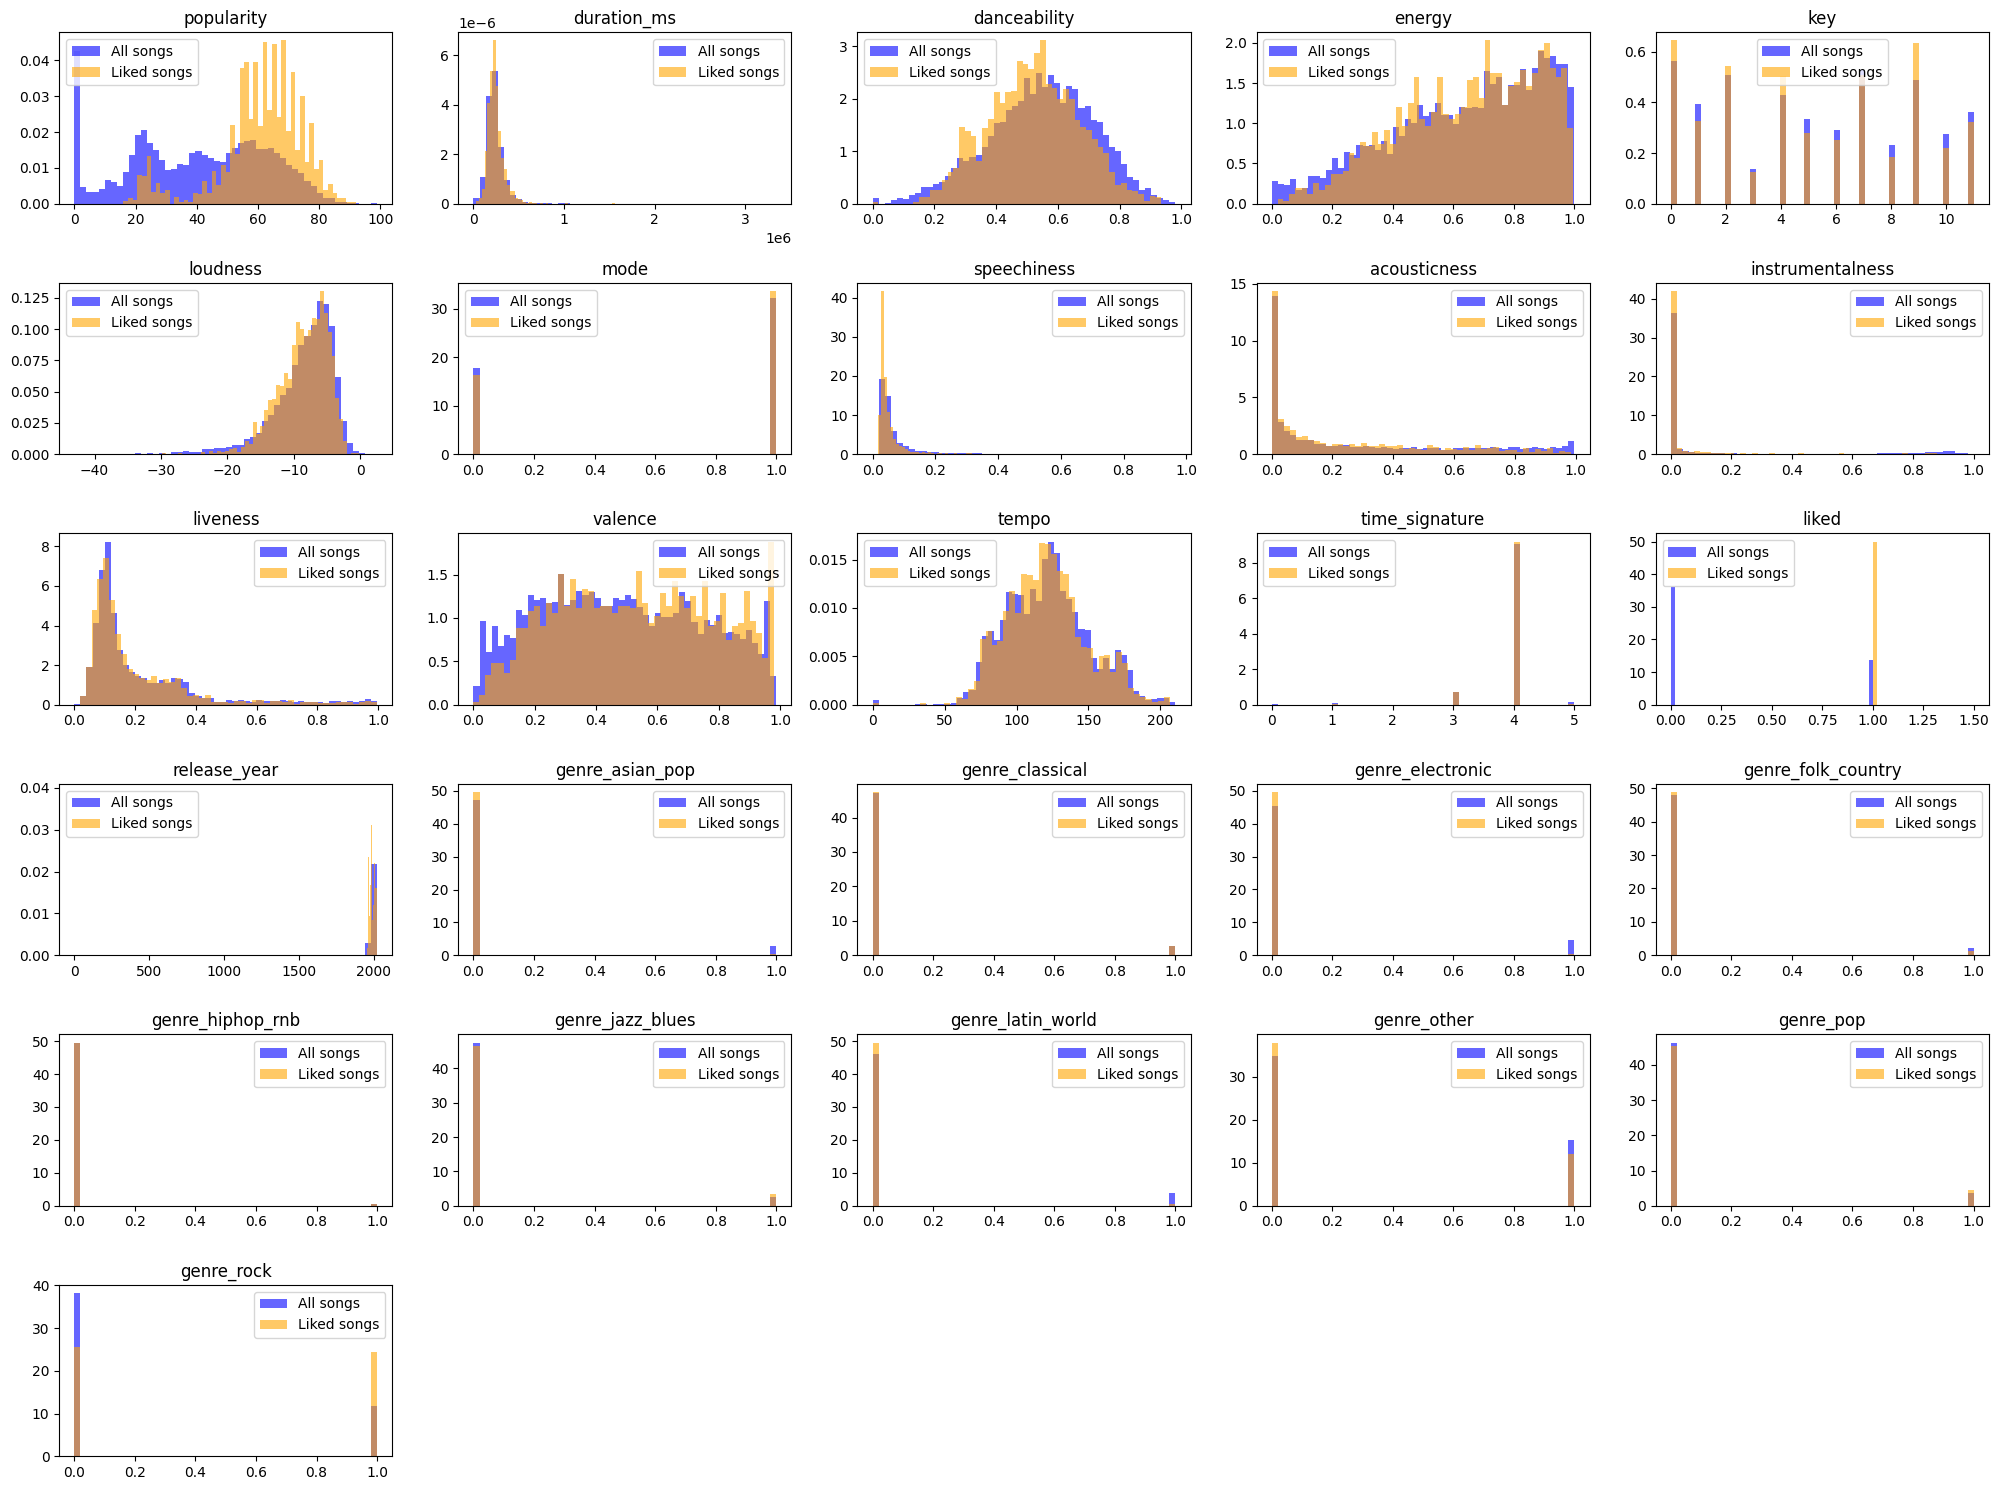

In [ ]:
df = pd.read_csv("reduced_data_encoded.csv")

# Ensure 'liked' is integer
df['liked'] = df['liked'].astype(int)

# Select numeric features (excluding index and unused encoded columns)
numerical_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Unnamed: 0'])

# Plot histograms
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(20, 15))
axes = axes.flatten()

for idx, col in enumerate(numerical_features.columns):
    ax = axes[idx]
    ax.hist(df[col], bins=50, alpha=0.6, label='All songs', color='blue', density=True)
    ax.hist(df[df['liked'] == 1][col], bins=50, alpha=0.6, label='Liked songs', color='orange', density=True)
    ax.set_title(col)
    ax.legend()

# Clean up any unused axes
for i in range(len(numerical_features.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()




<ipython-input-19-13fab42f3b38>:6: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


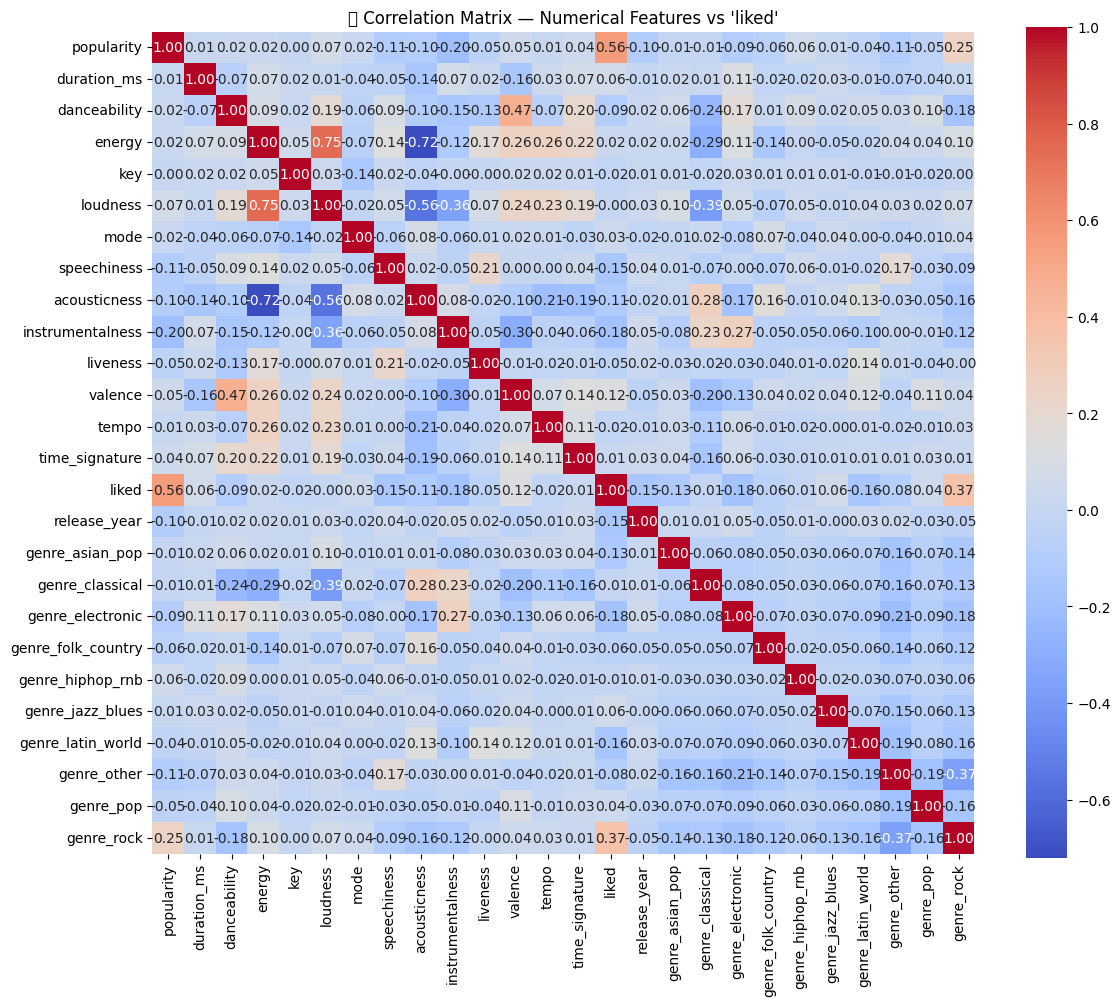

In [ ]:
plt.figure(figsize=(12, 10))
correlation_matrix = numerical_features.corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("🔍 Correlation Matrix — Numerical Features vs 'liked'")
plt.tight_layout()
plt.show()

### Feature Analysis and Genre Simplification

The analysis reveals that most audio features do not exhibit strong separability between liked and non-liked songs. According to the correlation matrix, only `popularity` and `release_year` show notable correlations with the `liked` label, at approximately 0.56 and -0.15 respectively. Features such as `valence`, `energy`, and `danceability` display weaker associations. This trend is further confirmed by the boxplots, where the distributions of most features appear similar across both classes. These observations indicate that no single audio feature is sufficient on its own to predict my preference.

Nonetheless, some general patterns emerge: my liked songs tend to be more popular, slightly less instrumental, and on average older than the rest of the dataset. This aligns with expected biasesthe selection of songs, as the dataset I got from the internet had less probability to contain unknown songs I liked than very famous ones.

It also shows my liking for music from the 1970s and 1980s.

To improve the interpretability of the `track_genre` feature, which originally contained 113 distinct values, I applied a manual regrouping to consolidate similar genres into 10 broader `main_genre` categories. This transformation proved effective: the encoded `main_genre` feature (`main_genre_encoded`) shows a stronger correlation with the `liked` label (0.31) compared to the original categorical variable (0.01). This suggests that reducing categorical noise and sparsity can enhance the feature's ability to reflect underlying user preferences, ultimately aiding future modeling tasks.


# pipeline: train/test split, standardization

### Preprocessing and Machine Learning Pipeline

Before training any models, we prepare the data properly. This section establishes the foundation for all supervised learning tasks in the project by constructing a consistent and reproducible pipeline:

- **Input features (`X`)** are derived by removing all non-numeric and non-informative columns (e.g., song titles, artist names, track IDs). These may be useful for display purposes (thus are stored in `info_df` and will be used in the Application section of this project) but not for modeling.
- The **target variable (`y`)** is binary, indicating a song is liked (`1`) or not (`0`)..
- The dataset is split into a **training set (85%)** and a **test set (15%)**, using `stratify=y` to preserve class balance. This ensures both sets maintain a similar distribution of liked and not liked songs.
- A **standardization step** using `StandardScaler` is applied to the features, which is essential for some models we will use later (logistic regression, MLP...) to perform optimally.



In [ ]:
df = pd.read_csv("reduced_data_encoded.csv")


info_df = df[['track_id', 'track_name', 'artists','album_name', 'main_genre']]

X = df.drop(columns=[
    'Unnamed: 0', 'liked', 'track_id', 'track_name', 'artists',
    'album_name', 'track_genre', 'main_genre'
])
# the dataframe info_df is likely to be useful at some point as we will like to go back to the name of the song to predict recommendations...

y = df['liked']

# Split train/test
X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(
    X, y, info_df, test_size=0.15, stratify=y, random_state=42
)

# === 3. Standardisation
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print(np.mean(X_train_scaled[:,0]))
print(np.std(X_train_scaled[:,0]))

1.2028923735935065e-16
1.0


# Principal Component Analysis

### PCA for Visualization and Exploratory Analysis

In this section, we use Principal Component Analysis (PCA) to project the high-dimensional song feature space into 2 dimensions. The goal is not to reduce dimensionality for training but to visualize whether liked and non-liked songs — or songs of similar genres — cluster together based on the selected features.

PCA finds orthogonal axes (principal components) that explain the most variance in the data. If user preferences correlate strongly with audio features, we might expect some visual separation between song classes.

We remind here that the data has been standardized before doing PCA.

## cumulative explained variance

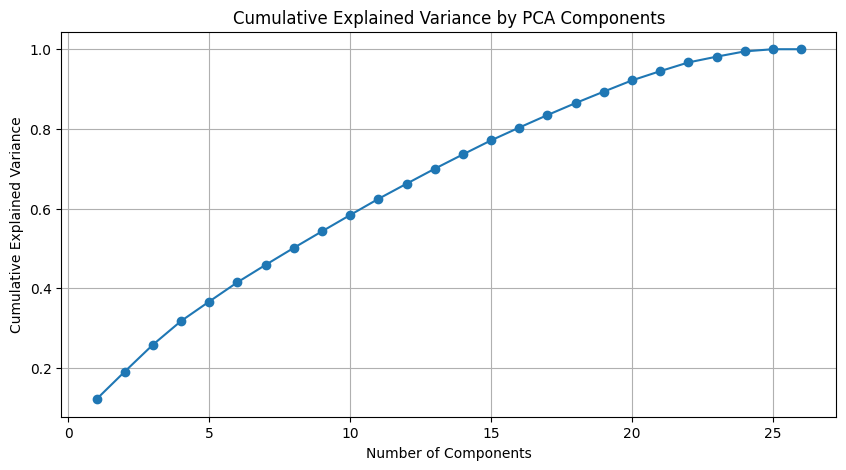

In [ ]:
df = pd.read_csv("reduced_data_encoded.csv")


pca = PCA().fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)


# 4. Plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

As shown in the cumulative variance plot, the first few components explain only a limited portion of the total variance. For example, it takes approximately **16 components** to explain 80% of the variance, indicating that the data is fairly high-dimensional and no single direction captures most of the information.

For visualization purposes, we project down to 2 components, acknowledging that this compression loses a significant amount of detail.


## 2D and 3D visualization: liked VS not liked songs

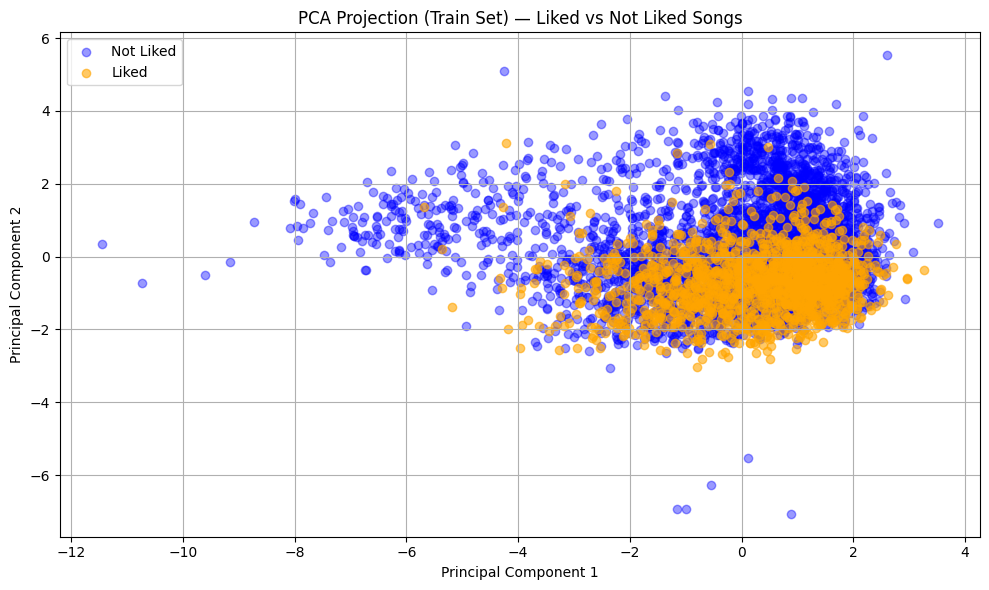

In [ ]:
pca = PCA(n_components=2).fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# visualisation on train
pca_train_df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
pca_train_df['liked'] = y_train.values

plt.figure(figsize=(10, 6))
plt.scatter(
    pca_train_df[pca_train_df['liked'] == 0]['PC1'],
    pca_train_df[pca_train_df['liked'] == 0]['PC2'],
    alpha=0.4, label='Not Liked', color='blue'
)
plt.scatter(
    pca_train_df[pca_train_df['liked'] == 1]['PC1'],
    pca_train_df[pca_train_df['liked'] == 1]['PC2'],
    alpha=0.6, label='Liked', color='orange'
)
plt.title("PCA Projection (Train Set) — Liked vs Not Liked Songs")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Fit PCA with 3 components
pca_3d = PCA(n_components=3).fit(X_train_scaled)
X_train_pca_3d = pca_3d.transform(X_train_scaled)

# Build dataframe for Plotly
pca_train_df_3d = pd.DataFrame(X_train_pca_3d, columns=['PC1', 'PC2', 'PC3'])
pca_train_df_3d['liked'] = y_train.values

# Create interactive plot
fig = px.scatter_3d(
    pca_train_df_3d, x='PC1', y='PC2', z='PC3',
    color=pca_train_df_3d['liked'].map({0: 'Not Liked', 1: 'Liked'}),
    title="Interactive 3D PCA Projection — Liked vs Not Liked Songs",
    labels={"color": "Liked"},
    opacity=0.7
)

fig.update_traces(marker=dict(size=4))
fig.show()

The 2D and 3D PCA projection shows that **liked and non-liked songs are not linearly separable** in the principal component space. While there is some clustering of liked songs on the bottom right-hand side of the 2D, a large overlap remains. This confirms earlier correlation results: no individual or linear combination of features is sufficient to separate user preferences.

It suggests that more flexible, non-linear classifiers may be necessary to capture subtle interactions in the feature space.

The 3D plot confirms that liked VS not liked songs tend to be clustered around different centers, but still overlap

## 2D and 3D visualization of genres

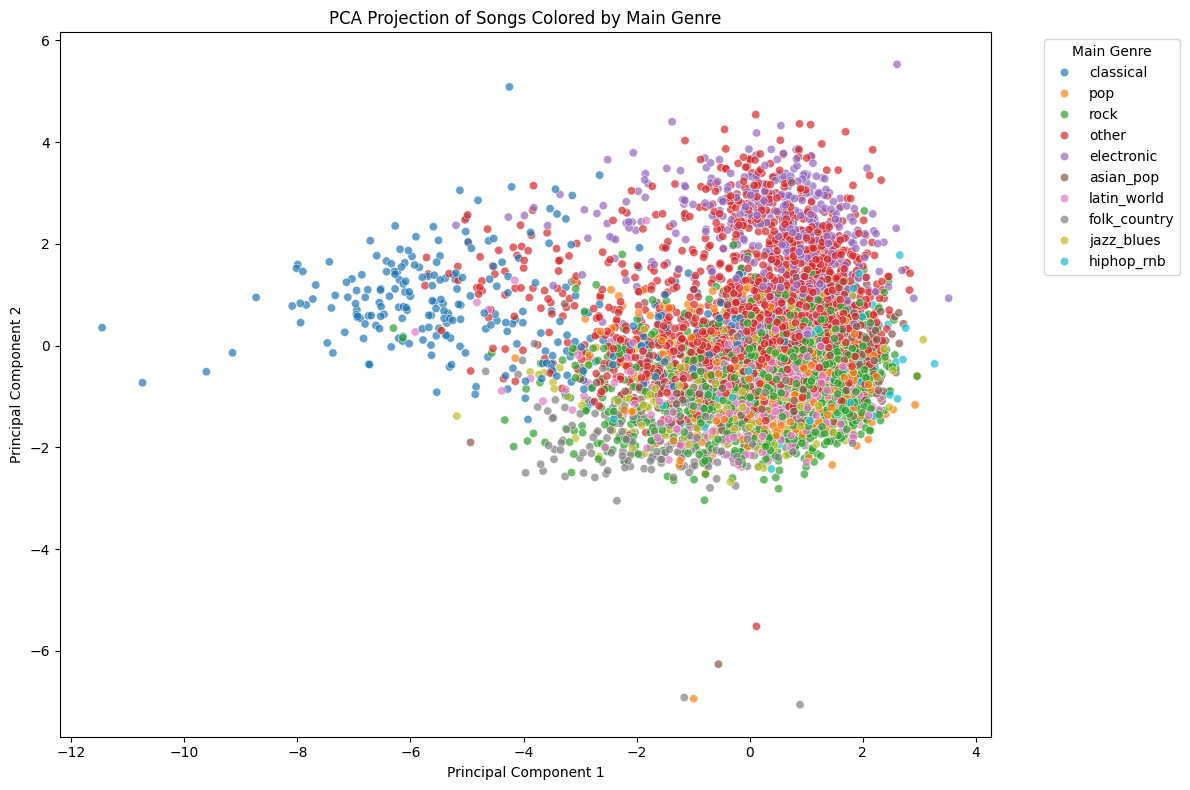

In [ ]:
# Combine PCA results with genre info
pca_train_df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
pca_train_df['main_genre'] = info_train['main_genre'].values

# Plot with seaborn for better color handling
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pca_train_df,
    x='PC1', y='PC2',
    hue='main_genre',
    palette='tab10',  # or try 'Set2', 'tab20', etc. depending on number of genres
    alpha=0.7
)
plt.title("PCA Projection of Songs Colored by Main Genre")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Main Genre')
plt.tight_layout()
plt.show()

The PCA projection colored by genre reveals loose groupings among certain music styles. For instance:
- Classical songs tend to cluster on the left, likely due to high acousticness and low tempo.
- Rock, pop, and electronic genres dominate the central and right regions, possibly due to shared energy, danceability, and valence characteristics.

This reinforces that genre encodes real patterns in audio features — justifying our use of genre groupings and their one-hot encoding in the modeling pipeline.

In [ ]:

import pandas as pd
from sklearn.decomposition import PCA

# --- PCA ---
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_scaled)

# --- Combine with genre info ---
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
pca_df["main_genre"] = info_train["main_genre"].values

# --- Plotly Express 3D Scatter with interactive legend ---
fig = px.scatter_3d(
    pca_df, x="PC1", y="PC2", z="PC3",
    color="main_genre",
    title="Interactive 3D PCA Projection by Genre",
    opacity=0.7
)

fig.update_layout(
    legend_title_text='Main Genre',
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


With the interactive 3D PCA plot (where genres can be toggled on or off) we observe that musical genres tend to form distinguishable clusters in the reduced feature space. This is expected, as each genre is characterized by a combination of specific audio attributes: for instance, Latin music typically shows higher danceability, while classical tracks often have longer durations and lower energy levels.

This visualization is particularly informative given that my playlist is heavily genre-oriented, with a strong emphasis on rock, pop, and jazz. The fact that genres are at least partially separable through PCA suggests that genre-related audio patterns are well captured by the available features. This is encouraging for the binary classification task that follows, as it supports the idea that my preference is strongly linked to genre, and that this can be inferred from audio descriptors through supervised learning.

# Supervised learning

## introduction and choice of scoring

### introduction

In this section, we train and compare multiple binary classification to predict whether a song will be liked or not based on its audio features and metadata.
We will use 5 models:
- Logistic Regression
- k-Nearest Neighbors (k-NN)
- Random Forest
- XGBoost
- Multi-layer Perceptron (MLP)



### Choice of Evaluation Metric: Why F1-Score?

In this project, we evaluate our models using the **F1-score**, which is particularly well-suited for imbalanced classification problems like this one. Our dataset contains more "not liked" songs than "liked" ones, meaning a naive model could perform well in terms of accuracy while completely failing to recommend relevant songs.

Precision and recall are defined as:

$$
\text{Precision} = \frac{TP}{TP + FP}, \quad \text{Recall} = \frac{TP}{TP + FN}
$$

Where:
- **TP** (True Positives): liked songs correctly predicted as liked  
- **FP** (False Positives): non-liked songs predicted as liked  
- **FN** (False Negatives): liked songs predicted as not liked  

In a recommendation system, we are especially interested in **precision** and **recall** for the positive class (class `1`, i.e., liked songs):
- **Precision on class 1**: the proportion of recommended songs that are truly liked. A low precision means too many irrelevant suggestions.
- **Recall on class 1**: the proportion of liked songs that are successfully recommended. A low recall means many good songs are missed.

The **F1-score** is defined as the harmonic mean of precision and recall:

$$
F_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}} = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}
$$

F1 balances both precision and recall, and is particularly relevant when both false positives and false negatives are costly — which is exactly the case for a recommendation task.

---

#### Why Not Accuracy?

Accuracy is defined as:

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

But this metric can be misleading. For example, if only **1/3 of the songs are liked** (roughly the proportion in our dataset), a model that always predicts “not liked” achieves **≈66% accuracy**, despite never recommending a single useful song.

Consider two models:
- **Model A**: predicts all songs as "not liked"  
  - Accuracy ≈ 66%  
  - Precision and recall = 0  
  - F1-score = 0

- **Model B**: makes meaningful recommendations with some errors  
  - Precision = 0.7, Recall = 0.6  
  - F1-score =  
    $$
    F_1 = \frac{2 \cdot 0.7 \cdot 0.6}{0.7 + 0.6} \approx 0.64
    $$
  - Clearly more valuable despite lower accuracy

---

#### Which f1 are we optimizing?

When using `scoring='f1'` in `GridSearchCV`, we are optimizing the **binary F1-score for class `1`**, meaning it focuses entirely on how well the model performs at detecting *liked songs*. This is distinct from other F1 scores reported in a classification report:

- `f1` (what we chose): F1-score for class 1 (liked songs)
- `f1_macro`: unweighted average of F1 scores for both classes  
- `f1_weighted`: weighted average based on class support  
- `f1_micro`: global F1 computed from total TP, FP, FN (less informative in binary setting)

Since **our goal is to recommend liked songs**, using the default `f1` scoring is both practically aligned with our objectives.

---

For these reasons, the F1-score on class 1 is the **most appropriate metric** for model evaluation and selection in this project.


## K-nearest neighbors

In [ ]:
param_grid = {'n_neighbors': list(range(1, 40))}

knn = KNeighborsClassifier()

grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train_scaled, y_train)
y_pred_knn = grid_knn.best_estimator_.predict(X_test_scaled)
# evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))
print("Best k:", grid_knn.best_params_['n_neighbors'])
print(classification_report(y_test, y_pred_knn))

Fitting 5 folds for each of 39 candidates, totalling 195 fits
Confusion Matrix:
[[643  63]
 [ 58 211]]
Best k: 15
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       706
           1       0.77      0.78      0.78       269

    accuracy                           0.88       975
   macro avg       0.84      0.85      0.85       975
weighted avg       0.88      0.88      0.88       975



### Results analysis



I included k-NN model as a form of baseline for the rest of the models.

The approach of k-NN seems to be aligned with the idea of music recommendation, as a son is likely to be appreciated if it is similar to other songs that one user already liked.

#### Best Parameter
- Best number of neighbors $k : 15$  
  Determined using $5$-fold cross-validation with F1-score as the optimization metric.

#### Performance Metrics

| Metric        | Class 0 (Not Liked) | Class 1 (Liked) |
|---------------|---------------------|-----------------|
| Precision     | 0.92                | 0.77            |
| Recall        | 0.91                | 0.78            |
| F1-score      | 0.91                | 0.78            |

- **Overall accuracy**: 88%
- **Macro F1-score**: 85%

#### Interpretation

- The k-NN classifier performs reasonably well overall, especially considering it is a non-parametric model.
- Performance on the majority class (Not Liked) is strong, with high precision and recall.
- For the minority class (Liked), the model achieves a recall of $73\%$, meaning it captures the majority of relevant songs
- The relatively high value of $k = 15$ indicates that the classifier relies on a broader neighborhood to smooth out noisy patterns in high-dimensional space.


## classification with logistic regression

In [ ]:
# training
logreg_cv = LogisticRegressionCV(
    penalty='l2',
    solver ='lbfgs',           # Required for ElasticNet
    Cs=10,                     # Number of C values to test
    cv=5,                      # 5-fold cross-validation
    scoring='f1',              # Optimize for F1-score
    max_iter=1000,
    random_state=42,
    n_jobs=-1                  # Use all CPUs
)

logreg_cv.fit(X_train_scaled, y_train)

# prediction
y_pred_log = logreg_cv.predict(X_test_scaled)

print("Best C value from CV:", logreg_cv.C_[0])

# evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_log))

Best C value from CV: 0.3593813663804626
Confusion Matrix:
[[642  64]
 [ 66 203]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       706
           1       0.76      0.75      0.76       269

    accuracy                           0.87       975
   macro avg       0.83      0.83      0.83       975
weighted avg       0.87      0.87      0.87       975



### Logistic Regression with L2 (Ridge) Regularization — Cross-Validated Results

After testing ElasticNet regularization, cross-validation selected a very low `l1_ratio` (0.1), indicating that the model relied almost entirely on L2 (Ridge) regularization. Based on this observation, a new model was trained using pure L2 regularization to simplify the model while retaining performance.

- **Best C value from cross-validation**: 0.36
  This corresponds to relatively high regularization strength, meaning the model performs best with high shrinkage of coefficients.

#### Performance Metrics

| Metric        | Class 0 (Not Liked) | Class 1 (Liked) |
|---------------|---------------------|-----------------|
| Precision     | 0.91                | 0.76            |
| Recall        | 0.91                | 0.75            |
| F1-score      | 0.91                | 0.76            |

- **Overall accuracy**: 87%
- **Macro F1-score**: 83%

#### Justification for L2 Regularization

- **L2 regularization** (Ridge) penalizes large coefficients but does **not** force them to zero. This is useful in cases where most features are informative to some degree, which aligns with the observations from earlier exploratory analysis.
- The model trained with L2 regularization achieves **similar performance** to the ElasticNet version, confirming that the additional sparsity constraint introduced by L1 was not necessary in this scenario.


## Random Forest

In [ ]:

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],        # number of trees
    'max_depth': [None, 10, 20],            # limit tree depth
    'min_samples_split': [2, 5, 10],        # min samples to split an internal node
    'min_samples_leaf': [1, 2, 4],          # min samples at a leaf
    'max_features': ['sqrt', 'log2']        # how many features to consider per split
}

# F1 scorer for binary classification
f1_scorer = make_scorer(f1_score)

# Initialize model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Grid search
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit on training data
grid_search_rf.fit(X_train, y_train)

# Best model
best_rf = grid_search_rf.best_estimator_
print("Best parameters:", grid_search_rf.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
# Predict
y_pred_rf = best_rf.predict(X_test)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Confusion Matrix:
[[678  28]
 [ 43 226]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       706
           1       0.89      0.84      0.86       269

    accuracy                           0.93       975
   macro avg       0.92      0.90      0.91       975
weighted avg       0.93      0.93      0.93       975



### Tuned Random Forest Classifier — Cross-Validated Results

A `GridSearchCV` was used to tune the Random Forest classifier using 5-fold cross-validation, with F1-score as the optimization metric. The following hyperparameters yielded the best performance:

- **Best parameters**:
  - `n_estimators`: 300
  - `max_depth`: None
  - `min_samples_split`: 2
  - `min_samples_leaf`: 1
  - `max_features`: 'sqrt'

#### Performance Metrics

| Metric        | Class 0 (Not Liked) | Class 1 (Liked) |
|---------------|---------------------|-----------------|
| Precision     | 0.94                | 0.89            |
| Recall        | 0.96                | 0.84            |
| F1-score      | 0.95                | 0.86            |

- **Overall accuracy**: 93%
- **Macro F1-score**: 91%

#### Interpretation

- The model achieves **high performance on both classes**, with particularly strong recall on "Not Liked" songs (96%) and a solid 85% recall on "Liked" songs.
- The use of cross-validation and hyperparameter tuning significantly improved generalization and reduced variance in the model's predictions.

## XGBoost

In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200, 250, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.5],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'reg_lambda': [5, 7],  # L2
    'reg_alpha': [0, 0.5]  # L1
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

In [ ]:
grid_search.fit(X_train_scaled, y_train)

# Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Confusion Matrix:
[[670  36]
 [ 34 235]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       706
           1       0.87      0.87      0.87       269

    accuracy                           0.93       975
   macro avg       0.91      0.91      0.91       975
weighted avg       0.93      0.93      0.93       975



In [ ]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.9}


**Best hyperparameters for XGBoost (after cross-validation):**

- `colsample_bytree`: 0.7  
- `learning_rate`: 0.1  
- `max_depth`: 5  
- `n_estimators`: 200  
- `reg_alpha`: 0  
- `reg_lambda`: 5  
- `subsample`: 0.9

#### Performance Metrics

| Metric        | Class 0 (Not Liked) | Class 1 (Liked) |
|---------------|---------------------|-----------------|
| Precision     | 0.94                | 0.87            |
| Recall        | 0.95                | 0.87            |
| F1-score      | 0.95                | 0.87            |

- **Overall accuracy**: 93%
- **Macro F1-score**: 91%

#### Interpretation

- XGBoost demonstrates **high and balanced performance** on both classes. Class 0 (Not Liked) is predicted with very high recall (95%), meaning most irrelevant songs are correctly filtered out.
- For Class 1 (Liked), the model achieves a strong **precision of 87%** and **recall of 87%**, indicating it successfully identifies a majority of relevant songs while keeping false positives relatively low.
- These results reflect a good trade-off between recommending new songs and avoiding poor suggestions — a key goal in building a music recommender system.
- The model benefits from cross-validation and hyperparameter tuning, which helped it generalize better and avoid overfitting on training data.

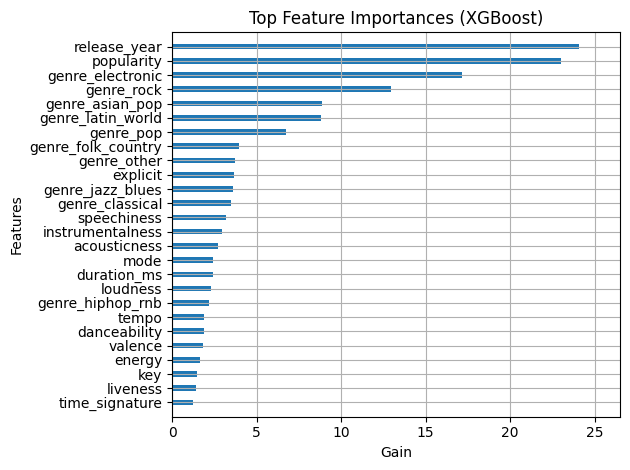

In [ ]:

# Plot with raw feature indices
ax = plot_importance(
    best_model,
    max_num_features=32,
    importance_type='gain',
    height=0.4,
    xlabel='Gain',
    show_values=False
)

# Fix labels with actual feature names
feature_names = X.columns.tolist()
top_features = [int(label.get_text()[1:]) for label in ax.get_yticklabels()]
ax.set_yticklabels([feature_names[i] for i in top_features])

plt.title("Top Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

### Feature Importance

The refined feature importance plot from the final XGBoost model provides valuable insights into what drives the recommendation predictions.

Unsurprisingly, **release year** and **popularity** remain the most critical predictors by a large margin. These two features contribute the most gain to the model’s decision trees, confirming that temporal and social signals are key indicators of whether a song is likely to be liked. This is consistent with prior correlation analysis.

Following them, genre-related features also play a significant role. One-hot encoded indicators such as `genre_electronic`, `genre_rock`, and `genre_asian_pop` rank just below the top two. This demonstrates that genre, while not linearly separable, provides useful structure when decomposed into binary features. These genre variables outperform most raw audio descriptors, confirming the benefit of semantic labeling over purely numeric audio features.

Meanwhile, audio features like `speechiness`, `acousticness`, `energy`, `valence`, and `tempo` contribute only marginally to the model's performance. This highlights that while such descriptors may describe the mood or texture of a song, they do not strongly correlate with my personal preference. Even technical properties like `duration_ms`, `key`, and `time_signature` are nearly negligible in predictive importance.

Overall, this analysis emphasizes that **contextual metadata (release year, popularity) and categorical features (genre)** are significantly more informative for personal music recommendations than raw audio analysis. This supports the earlier finding that filtering the dataset solely based on available audio features may not be the most impactful strategy for improving recommendation quality.


## MLP

To complement the other models used in this project, I added a Multi-Layer Perceptron (MLP) as a non-linear, parametric approach.

The model was built a using scikit-learn’s MLPClassifier, with first a heuristic approach for the exploration of parameters.

To optimize the architecture and training parameters of the Multi-Layer Perceptron (MLP), we adopt an **evolutionary cross-validation** approach. Rather than exhaustively testing a massive grid of hyperparameters at once (which is computationally expensive and often inefficient), we start with a chosen initial grid of plausible configurations.
Once the first cross-validation run is complete, we update the parameter grid based on the best-performing model. This could involve narrowing the learning rate range, adding more hidden layer variants around the optimal size, or fine-tuning regularization strength (alpha). This iterative process allows us to progressively refine the model while avoiding unnecessary exploration of suboptimal regions of the hyperparameter space.

In [ ]:
# iteration 3 of our CV evolution
param_grid = {
    'hidden_layer_sizes': [
        (100, 60, 30, 15),
        (128, 64),
        (64, 64, 64),
        (128, 32),
        (50, 30)  # keep current best for reference
    ],
    'alpha': [1e-7, 1e-6, 1e-5, 1e-4],
    'learning_rate_init': [0.001, 0.005, 0.01],
    'activation': ['tanh','relu'],
    'early_stopping': [True]
}

mlp = MLPClassifier(
    max_iter=1000,
    random_state=42
)

grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search_mlp.fit(X_train_scaled, y_train)

# Evaluate best model
best_mlp = grid_search_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test_scaled)

grid_search_mlp.best_score_
print("Best score:", grid_search_mlp.best_score_)
print("Best parameters:", grid_search_mlp.best_params_)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_mlp))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp))


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best score: 0.8500934817196969
Best parameters: {'activation': 'tanh', 'alpha': 1e-07, 'early_stopping': True, 'hidden_layer_sizes': (50, 30), 'learning_rate_init': 0.01}
Confusion Matrix:
[[658  48]
 [ 38 231]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       706
           1       0.83      0.86      0.84       269

    accuracy                           0.91       975
   macro avg       0.89      0.90      0.89       975
weighted avg       0.91      0.91      0.91       975



### Cross-Validation Results for MLPClassifier

| CV Round | Hidden Layer Sizes | Alpha   | Learning Rate Init | Activation | Early Stopping | Best F1 Score (CV) |
|----------|---------------------|---------|---------------------|------------|----------------|---------------------|
| CV 1     | (50, 30)            | 0.00001 | 0.01                | tanh       | True           | 0.850               |
| CV 2     | (50, 30)            | 0.000001| 0.01                | tanh       | True           | 0.850               |
| CV 3     | (50, 30)             | 0.0000001| 0.01               | tanh       | True           | 0.850               |

Although I really tried to tweak the values of the cross-validation parameter grid, it seems like we already reached a local minimum at step 1, and after only the alpha decreased.


### Performance and Interpretation

| Metric        | Class 0 (Not Liked) | Class 1 (Liked) |
|---------------|---------------------|-----------------|
| Precision     | 0.95                | 0.83            |
| Recall        | 0.93                | 0.86            |
| F1-score      | 0.94                | 0.84            |

- **Overall accuracy**: 91%  
- **Macro F1-score**: 89%

The MLP achieved solid overall performance, with balanced precision and recall on both classes. However, its results are slightly below those of XGBoost classifier, particularly in identifying liked songs, where it reaches 83% precision.


## Model comparison

### Performance Comparison

| Model               | F1-score (Liked) | Precision (Liked) | Recall (Liked) | Macro F1-score |
|---------------------|------------------|--------------------|----------------|----------------|
| k-NN (k=15)         | 0.78             | 0.77               | 0.78           | 0.85           |
| Logistic Regression | 0.76             | 0.76               | 0.75           | 0.83           |
| Random Forest       | 0.86             | 0.89               | 0.84           | 0.91           |
| XGBoost             | 0.87             | 0.87               | 0.87           | 0.91           |
| MLP (tanh)          | 0.84             | 0.83               | 0.86           | 0.89           |


### Commentary on Model Comparison

This table summarizes the performance of all tested supervised learning models, with a particular focus on their effectiveness at identifying songs the user is likely to enjoy — i.e., class `1`. Among the various evaluation metrics, the **F1-score for class 1** is the most relevant in our context: it reflects the model's ability to both **recommend relevant songs (precision)** and **not miss too many liked songs (recall)**.

From the results, we observe the following:

- **Logistic Regression** and **k-NN** yield the weakest performance, with F1-scores of **0.76** and **0.78**, respectively. These models underperform especially in recall, meaning they miss a significant number of songs the user would like. This makes them unreliable for building a high-quality recommender system.
  
- **Random Forest** and **XGBoost** stand out as the most effective models. XGBoost achieves the best **macro F1-score of 0.91**, and a **class 1 F1-score of 0.87**, with balanced precision (0.87) and recall (0.87). These results indicate that XGBoost offers the best compromise between catching enough liked songs and avoiding irrelevant ones.

- **MLP** reaches a strong **F1-score of 0.84** for liked songs, with slightly higher recall (0.86) than precision (0.83). While not surpassing XGBoost, it remains competitive and highlights the model's ability to learn non-linear patterns.

In conclusion, **XGBoost is the most effective model** in this setting, offering a consistent edge over others in all relevant metrics. Its performance justifies its use for generating the final recommendation playlist. MLP comes close, especially in recall, and may be preferred in situations where false negatives (missed liked songs) are more critical than false positives.


# Application: recommendation function

## Applying the Model to Unseen Songs

To generate new recommendations, we apply the model to a portion of the dataset that was **not used during training**. This ensures we only evaluate on truly unseen data, avoiding information leakage and overfitting. Specifically, we filter out any songs that were included in the reduced training dataset.

This approach provides a realistic simulation of how the model would perform in a real-world setting: recommending new tracks the user hasn't already interacted with. It helps assess the model’s generalization ability and ensures that the final playlist contains fresh content, not songs the model was already trained on.

### Extract not seen songs from the whole dataset


In [ ]:
# Load the datasets
df_full = pd.read_csv("data_encoded.csv")
df_train = pd.read_csv("reduced_data_encoded.csv")

# Drop rows used in training (based on unique track_id)
unseen_df = df_full[~df_full['track_id'].isin(df_train['track_id'])].copy()

# Drop non-numeric or irrelevant columns
info_cols = ['track_id', 'track_name', 'artists', 'album_name', 'track_genre']
info_unseen = unseen_df[info_cols]

# Ensure X_unseen has the exact same columns as training set
X_unseen = unseen_df[X_train.columns]  # use same column order and names

# We use the same scaler as the one used for training the data
X_unseen_scaled = scaler.transform(X_unseen)

# we will need to retrieve info about the song (name, artist, genre...)
info_unseen = unseen_df[['track_id', 'track_name', 'artists', 'album_name', 'main_genre']]


In [ ]:
unseen_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74846 entries, 0 to 81342
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          74846 non-null  int64  
 1   track_id            74846 non-null  object 
 2   artists             74846 non-null  object 
 3   album_name          74846 non-null  object 
 4   track_name          74846 non-null  object 
 5   popularity          74846 non-null  int64  
 6   duration_ms         74846 non-null  int64  
 7   explicit            74846 non-null  bool   
 8   danceability        74846 non-null  float64
 9   energy              74846 non-null  float64
 10  key                 74846 non-null  int64  
 11  loudness            74846 non-null  float64
 12  mode                74846 non-null  int64  
 13  speechiness         74846 non-null  float64
 14  acousticness        74846 non-null  float64
 15  instrumentalness    74846 non-null  float64
 16  liveness 

## random song liking probability

In [ ]:
def predict_like_probability_unseen(model, X_unseen_scaled, info_unseen, song_index=None):
    """
    Predict the probability of liking a song from the unseen dataset.
    Returns:
        float: Probability of liking the song
        int: Index of the selected song
    """
    if song_index is None:
        song_index = random.randint(0, len(X_unseen_scaled) - 1)

    x_scaled = X_unseen_scaled[song_index].reshape(1, -1)
    prob = model.predict_proba(x_scaled)[0, 1]

    return prob, song_index


# Run it on a random song from unseen data
prob, song_index = predict_like_probability_unseen(best_model, X_unseen_scaled, info_unseen)

print("🎧 Song:", info_unseen.iloc[song_index]['track_name'], "by", info_unseen.iloc[song_index]['artists'])
print(f"🔮 Probability of liking this song: {prob:.2%}")


🎧 Song: For a Moment by Five Star Hotel;Spirit Waves
🔮 Probability of liking this song: 0.15%


## song recommendation algorithm

In [ ]:
def recommend_songs_on_unseen(model, X_unseen_scaled, info_unseen, num_recommendations=10, genre=None):
    """
    Recommend top N songs from the unseen dataset.


    Returns:
        pd.DataFrame: Top recommended songs with their predicted probabilities
    """
    df = info_unseen.copy()

    # Apply genre filter if needed
    if genre:
        mask = df['main_genre'] == genre
        df = df[mask]
        X_scaled = X_unseen_scaled[mask]
    else:
        X_scaled = X_unseen_scaled

    # Predict probabilities
    df['predicted_liked_score'] = model.predict_proba(X_scaled)[:, 1]

    # Sort and return top N
    recommended = df.sort_values(by='predicted_liked_score', ascending=False).head(num_recommendations)
    return recommended[['track_id', 'track_name', 'artists', 'main_genre', 'predicted_liked_score']]


In [ ]:
top_recs = recommend_songs_on_unseen(
    model = best_model,
    X_unseen_scaled = X_unseen_scaled,
    info_unseen = info_unseen,
    num_recommendations=10,
    genre='rock'
)

top_recs.head()

,track_id,track_name,artists,main_genre,predicted_liked_score
63072,7F02x6EKYIQV3VcTaTm7oN,Hey You,Pink Floyd,rock,0.998123
31336,79MMMdYL00iwKVHBSAUkLY,I Wanna Be Your Dog - 2019 Remaster,The Stooges,rock,0.997953
65231,542C7PqR1oEfl63hlhQO4V,The Most Beautiful Girl,Charlie Rich,rock,0.997875
63268,3XxBSvDZKH5YvZZjTpn6eR,Red House,Jimi Hendrix,rock,0.997534
63096,4JMRpe5sUhYjOlf0JE4BT8,A Feast of Friends,Jim Morrison,rock,0.997383


## recommendation playlist creation

To have a real-life application of our project, I want to create a real Spotify playlist based on our best model (XGBoost). We select the songs with the highest probability to be liked by myself in the dataframe containing all the songs that were not used for training ("unseen data") and potentially filter by genre.

In [ ]:
# recommended tracks
recommended_tracks = recommend_songs_on_unseen(
    model = best_model,
    X_unseen_scaled = X_unseen_scaled,
    info_unseen = info_unseen,
    num_recommendations=100,
    genre='rock')
track_ids = recommended_tracks['track_id'].tolist()

In [ ]:
## creating the playlist

playlist_name = 'ML recommendations'
playlist_description = 'Songs recommended by my ML model based on my tastes.'

create_url = f"https://api.spotify.com/v1/users/{user_id}/playlists"
headers = {
    'Authorization': f'Bearer {access_token}',
    'Content-Type': 'application/json'
}
data = {
    "name": playlist_name,
    "description": playlist_description,
    "public": True
}

response = requests.post(create_url, headers=headers, json=data)

if response.status_code != 201:
    print("Failed to create playlist.")
    print("Status code:", response.status_code)
    print("Response:", response.json())
    raise Exception("Playlist creation failed.")

playlist = response.json()
playlist_id = playlist['id']
playlist_url = playlist['external_urls']['spotify']
print("Created playlist:", playlist_url)

Created playlist: https://open.spotify.com/playlist/3H6NguBvjAXcIKTc4iWlBb


In [ ]:
## == add the tracks ==
add_tracks_url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
uris = [f"spotify:track:{track_id}" for track_id in track_ids]
response = requests.post(add_tracks_url, headers=headers, json={"uris": uris})
print("Tracks added.")


Tracks added.


### Spotify ML recommendation playlist

To make the recommendation system tangible, a new Spotify playlist was created using the top 100 tracks predicted by the final model. These tracks were not previously liked, but were assigned high probabilities of being liked based on the my preferences.
You can access the original playlist and the newly created one with these links:

- **Original liked playlist**: [My Liked Songs](https://open.spotify.com/playlist/3zU9kDDrBvxPaKB6vSDo4Z?si=101b3230e98844b8)
- **New ML-generated playlist**: [Recommendations by Model](https://open.spotify.com/playlist/3H6NguBvjAXcIKTc4iWlBb)

After listening to this playlist, I confirm that the model has capture my taste for older rock tracks, and the playlist is very well-suited to my taste:
- it is well balanced: not only rock tracks, but genres diversity (rock, reggae, pop, electro)
- has popular and less popular artists
- was able to make me discover new tracks and artists.

# Remarks, critics, improvements and conclusion

## Remarks and critical perspective

While the system achieved strong predictive performance and produced coherent song recommendations, several limitations and biases emerged during development that are worth addressing.

### Dataset Bias and Cultural Representation

One important issue is the **lack of representation of French songs** in the final recommendation playlist. As a chanson française fan, many of the tracks I enjoy are in French, as can be observed in the original playlist link found above.

However, the dataset used to extract audio features — which contained over 80,000 tracks — was biased toward popular, English-language music. Since only songs with available audio features were retained, most French songs from my liked playlist were filtered out.

This resulted in a model that simply did not have access to a key part of my music taste. As a result, the final recommendations contained **no French songs**, despite the original playlist including hundreds of them. This highlights the importance of **dataset coverage and diversity** in building personalized recommendation systems.


### Audio Features and Feature Importance

Another important observation concerns the **limited impact of raw audio features** on the prediction of my preferences.

Despite using a large dataset with detailed acoustic descriptors ( `valence`, `danceability`, `energy`, etc.), the most predictive features were consistently **`popularity`, `release year`, and `main genre`**.

Audio features like `instrumentalness`, `speechiness`, or `tempo`@ showed minimal correlation with the target variable. This suggests that my taste is less dependent on audio signal characteristics and more aligned with **cultural context** — such as time period, style, and visibility of an artist.

Given this, the entire preprocessing step where I matched my liked songs against a dataset of audio features — and dropped unmatched tracks — may have been counterproductive. A better approach might be to **build a dataset from scratch**, starting with a large, diverse collection of songs (including niche or regional ones), and labeling them based on personal preference — even if that means **omitting audio features entirely**. This would preserve the full range of cultural and linguistic diversity in my taste, and allow the model to train on the actual patterns that matter.

### Absence of Crossed and Interaction Features

Another limitation lies in the **feature engineering strategy**: the model only considered raw features individually. However, it is likely that **interactions between features** carry valuable information.

For instance:

- The impact of a song’s popularity might vary by genre (popular pop songs may be well-liked, whereas popularity in classical music might not be as relevant).
- Songs from the 1970s with high instrumentalness might align with my taste, whereas similar values in more recent songs might not.
- The effect of explicit lyrics could be genre-dependent — tolerated or even appreciated in hip-hop, but not in other genres like jazz or folk.

Incorporating **cross features** or **interaction terms** (`genre x popularity`, `release_year x acousticness`) could help models capture these types of patterns. These features could be added manually based on domain intuition, or generated automatically using polynomial feature expansion or interaction-aware methods in tree-based models. This would likely improve the model’s ability to detect complex relationships in the data and ultimately yield better recommendations.


## Additional Improvements and Future Work

- As mentionned, a valuable direction would be to collect a **custom dataset** containing metadata such as title, artist, genre, popularity, release year, language, etc., and use it as the core feature set.
- Implementing **language detection** (for instance based on artist name or track title) could help explicitly model cultural taste and avoid oversampling English music.
- Expanding the application to include **user feedback**, or running it with a group of users, could enable iterative improvement and even collaborative filtering.



## Conclusion

This project demonstrated how machine learning can be used to build a personalized music recommendation system. Starting from a playlist of songs I liked, I trained and compared several supervised models — including logistic regression, k-nearest neighbors, random forests, XGBoost, and a neural network — to predict whether I would enjoy a new song based on its features.

The results showed that tree-based models, particularly XGBoost, delivered the best performance, followed closely by a well-tuned MLP. However, the most important insight came from analyzing feature importance: rather than audio characteristics like tempo or valence, the most predictive features were popularity, release year, and genre. This suggests that user preferences are often shaped more by cultural and contextual factors than by raw audio features.

A key limitation was the bias introduced by the external dataset used for feature extraction. Many songs I like — especially French tracks — were excluded simply because they weren’t present in the dataset. As a result, the final recommendations lacked representation of an important part of my taste. In future work, building a custom dataset that preserves all liked songs and focuses on relevant metadata could lead to more inclusive and accurate recommendations.

Overall, this project showed that while algorithms are powerful, their success depends heavily on data quality, coverage, and the thoughtful design of input features.
